In [1]:
from __future__ import division, print_function, absolute_import
import csv
import pandas
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    double_reaction_deletion)
import os
import xml.etree.ElementTree as etree
import cobra
import numpy as np
from itertools import chain
from cobra.util import solver as sutil
from cobra.core.solution import get_solution
from optlang.symbolics import add, Zero
import pandas as pd
import os
from os.path import join
import matplotlib.pyplot as plt
from cobra.medium import minimal_medium
# Press ⌃R to execute it or replace it with your code.
# Press Double ⇧ to search everywhere for classes, files, tool windows, actions, and settings.
from cobra.flux_analysis import production_envelope
from cobra import Model, Reaction, Metabolite
from cobra.flux_analysis import flux_variability_analysis
import matplotlib.pyplot as plt
from cobra.io import load_json_model, save_json_model, load_matlab_model, save_matlab_model, read_sbml_model, write_sbml_model



In [2]:
## Pareto function
# Pareto
objective1={''}
objective2={''}
pareto_range = (0.0, 1.001)  # for some reason you need to pick a number higher than 1).
pareto_step_size = 0.01
analysis_type = 'pareto'
metric = 'manhattan'
rxn2avoid = {''}
solver='gurobi'
constants = {'deltaC_CO2': 0.0055, 'D_H2O_0': 2.13E-05, 'D_CO2_0': 1.33E-05, 'mid_day': 6, 'deltaT': 2,
             'FeasTol': 1e-03, 'OptTol': 1e-03}
def pareto_analysis(model, objective1=objective1, objective2=objective2, pareto_range=pareto_range, metric=metric):
    reaction_obj1 = model.reactions.get_by_id(objective1)
    reaction_obj2 = model.reactions.get_by_id(objective2)
    result_list = []
    model.objective = {}
    reaction_obj1.objective_coefficient = 1
    solution = model.optimize()
    print("\nSolving model (FBA) for determining objective 1 flux...")
    max_obj1 = dict(solution.fluxes)[objective1]
    print("Max {0}: {1}".format(objective1, max_obj1))
    # change objective
    reaction_obj1.objective_coefficient = 0
    reaction_obj2.objective_coefficient = 1
    print("\nSolving all iterations for Pareto frontier (FBA)...")
    for pareto in np.arange(pareto_range[0], pareto_range[1], pareto_step_size):
        if pareto == 1:
            reaction_obj1.lower_bound = max_obj1 * pareto  # * 0.999 # we need to add a bit of slack as the quadratic optimization is less accurate than the linear couterpart
        else:
            reaction_obj1.lower_bound = max_obj1 * pareto  # * 0.9999
        sol = model.optimize(objective_sense='maximize')
        # fix this minimal water loss value
        reaction_obj2.bounds = (sol.get_primal_by_id(objective2), sol.get_primal_by_id(objective2))
        if metric == 'manhattan':
            solution = cobra.flux_analysis.pfba(model)
            # print({'proline sink': solution['SK_PRO_c_06'], 'biomass 05': solution['Leaf_biomass_tx_05'], 'biomass 06': solution['Leaf_biomass_tx_06']})
            # solution.fluxes.to_excel(f'pareto_no_{pareto}.xlsx')
            result_list.append([pareto, solution[objective1], solution[objective2]])
            reaction_obj2.bounds = (0, 1000.0)
        elif metric == 'euclidean':

            # make copy because that is easier that reverting all the solver settings
            copy_model = model.copy()
            model.solver = solver

            FeasTol = float(constants['FeasTol'])
            OptTol = float(constants['OptTol'])

            copy_model.solver.configuration.tolerances.feasibility = FeasTol
            copy_model.solver.configuration.tolerances.optimality = OptTol

            rxnlist = [r for r in copy_model.reactions if r.id not in rxn2avoid]

            obj_vars = chain.from_iterable([r.flux_expression ** 2] for r in rxnlist)
            copy_model.objective = copy_model.problem.Objective(add(obj_vars), direction='min')

            print('\nSolving quadratic minimisation of sum of fluxes')
            #print(solver)
            solution = copy_model.optimize(objective_sense=None)
            result_list.append([pareto, solution[objective1], solution[objective2]])
        reaction_obj2.bounds = (0, 1000.0)
    return result_list

In [23]:
model_rs = read_sbml_model('beta_day_RS_DM.xml')


In [24]:
core_model=model_rs
#core_model.metabolites.query('OXIDIZED')
#core_model.metabolites.get_by_id('OXIDIZED_GLUTATHIONE_m')

In [25]:
##Constraints
rubisco = core_model.problem.Constraint(3 * core_model.reactions.get_by_id("RXN_961_p").flux_expression - core_model.reactions.get_by_id("RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p").flux_expression,lb=0, ub=0,)
core_model.add_cons_vars([rubisco])
## 
atp = core_model.problem.Constraint((0.0049*core_model.reactions.get_by_id("Photon_tx").flux_expression+2.7851)-core_model.reactions.get_by_id("ATPase_tx").flux_expression, lb=0, ub=0)
core_model.add_cons_vars(atp)
##
atp_nadph_03 = core_model.problem.Constraint(3 * (core_model.reactions.get_by_id("NADPHoxm_tx").flux_expression + core_model.reactions.get_by_id("NADPHoxc_tx").flux_expression + core_model.reactions.get_by_id("NADPHoxp_tx").flux_expression) - core_model.reactions.get_by_id("ATPase_tx").flux_expression, lb=0, ub=0)
core_model.add_cons_vars(atp_nadph_03)

In [26]:
## biotic
h2o2_biotic = core_model.problem.Constraint(core_model.reactions.get_by_id("H2O2_p_demand").flux_expression + core_model.reactions.get_by_id("H2O2_m_demand").flux_expression + core_model.reactions.get_by_id("H2O2_x_demand").flux_expression + core_model.reactions.get_by_id("H2O2_e_demand").flux_expression, lb=0, ub=0.002339457096)
core_model.add_cons_vars(h2o2_biotic)
#
o2s_biotic = core_model.problem.Constraint(core_model.reactions.get_by_id("Super_oxide_p_demand").flux_expression + core_model.reactions.get_by_id("Super_oxide_m_demand").flux_expression + core_model.reactions.get_by_id("Super_oxide_x_demand").flux_expression, lb=0, ub=0.00440746474)
core_model.add_cons_vars(o2s_biotic)

## drought
#h2o2_drought = core_model.problem.Constraint(core_model.reactions.get_by_id("H2O2_p_demand").flux_expression + core_model.reactions.get_by_id("H2O2_m_demand").flux_expression + core_model.reactions.get_by_id("H2O2_x_demand").flux_expression + core_model.reactions.get_by_id("H2O2_e_demand").flux_expression, lb=0, ub=13.24)
#core_model.add_cons_vars(h2o2_drought)

##
h2o2_uvb = core_model.problem.Constraint(core_model.reactions.get_by_id("H2O2_p_demand").flux_expression + core_model.reactions.get_by_id("H2O2_m_demand").flux_expression + core_model.reactions.get_by_id("H2O2_x_demand").flux_expression, lb=0, ub=7.476968447)
#core_model.add_cons_vars(h2o2_uvb)
#
o2s_uvb = core_model.problem.Constraint(core_model.reactions.get_by_id("Super_oxide_p_demand").flux_expression + core_model.reactions.get_by_id("Super_oxide_m_demand").flux_expression + core_model.reactions.get_by_id("Super_oxide_x_demand").flux_expression, lb=0, ub=0.0001540487974)
#core_model.add_cons_vars(o2s_uvb)

## ellicitors
h2o2_ell = core_model.problem.Constraint(core_model.reactions.get_by_id("H2O2_p_demand").flux_expression + core_model.reactions.get_by_id("H2O2_m_demand").flux_expression + core_model.reactions.get_by_id("H2O2_x_demand").flux_expression + core_model.reactions.get_by_id("H2O2_e_demand").flux_expression, lb=0, ub=0.03415905925)
#core_model.add_cons_vars(h2o2_ell)
#
o2s_ell = core_model.problem.Constraint(core_model.reactions.get_by_id("Super_oxide_p_demand").flux_expression + core_model.reactions.get_by_id("Super_oxide_m_demand").flux_expression + core_model.reactions.get_by_id("Super_oxide_x_demand").flux_expression, lb=0, ub=0.00585384449)
#core_model.add_cons_vars(o2s_ell)

## Nitric oxide
h2o2_demand = core_model.problem.Constraint(core_model.reactions.get_by_id("DM_NITRIC-OXIDE_cell").flux_expression, lb=0, ub=0.0001802061558)
core_model.add_cons_vars(h2o2_demand)



Solving model (FBA) for determining objective 1 flux...
Max DM_HYDROGEN_PEROXIDE_cell: 73.58280306188134

Solving all iterations for Pareto frontier (FBA)...
        0          1         2
0    0.00   0.000000  0.215272
1    0.01   0.735828  0.213758
2    0.02   1.471656  0.212240
3    0.03   2.207484  0.210721
4    0.04   2.943312  0.209202
..    ...        ...       ...
96   0.96  70.639491  0.009391
97   0.97  71.375319  0.007044
98   0.98  72.111147  0.004697
99   0.99  72.846975  0.002351
100  1.00  73.582803  0.000000

[101 rows x 3 columns]


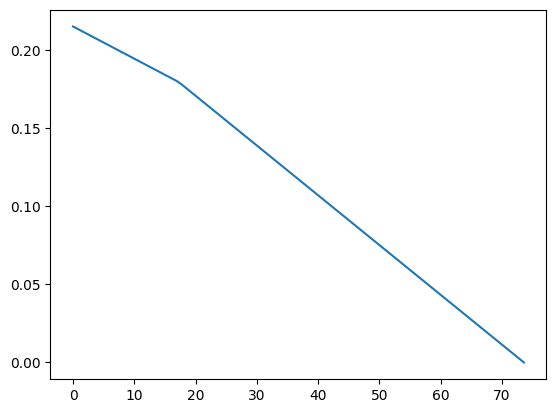

In [27]:
## plot pareto plot
objective1 =  'DM_HYDROGEN_PEROXIDE_cell'
objective2 =  'AraCore_Biomass_tx'
solution_primary=pareto_analysis(core_model, objective1 = objective1, objective2=objective2, pareto_range = pareto_range, metric = metric)
#pd.DataFrame(result_list).to_excel('results.xlsx')
data=pd.DataFrame(solution_primary)
print(data)
plt.plot(data[1],data[2]) 
#plt.ylim([0.2152,0.2153])
#plt.xlim([0,0.03])
plt.show()##
#objs_rs=[AraCore_Biomass_tx 'Phloem_output_tx','DM_NITRIC-OXIDE_cell','DM_HS_cell','DM_SUPER_OXIDE_cell','DM_HC00250_cell','DM_CPD0-1395_cell','DM_SO3_cell','DM_CPD-12377_cell','DM_HYDROGEN_PEROXIDE_cell','DM_ho2_rad_cell']